In [179]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
import nltk
import csv
import networkx as nx
import operator
import matplotlib.pyplot as plt
import pandas as pd
import re

##### loading the data

In [180]:
nltk.download('punkt') # for tokenization
nltk.download('stopwords')
stpwds = set(nltk.corpus.stopwords.words("english"))
stemmer = nltk.stem.PorterStemmer()

#with open("testing_set.txt", "r") as f:
#    reader = csv.reader(f)
#    testing_set  = list(reader)

#testing_set = [element[0].split(" ") for element in testing_set]

#with open("training_set.txt", "r") as f:
#    reader = csv.reader(f)
#    training_set  = list(reader)

#training_set = [element[0].split(" ") for element in training_set]

training_set = np.array(pd.read_csv("paul_my_train.csv").values)
testing_set = np.array(pd.read_csv("paul_my_test.csv").values)

with open("node_information.csv", "r") as f:
    reader = csv.reader(f)
    node_info  = list(reader)

IDs = [element[0] for element in node_info]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kingr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kingr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [181]:
print(paul_training_set[0][2])

1


##### Graph features computation on authors and articles

##### one might want to add the option of a directed link only if the temporal difference allows us todo so

In [182]:
def graph_articles(citation_set, node_info, directed_or_not = 'n'):
    if directed_or_not == 'y':
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    for node in node_info:
        if node[0] != 'ID':
            print(int(node[0]))
            G.add_node(int(node[0]), year = node[1])
    for i in citation_set:
        if i[2] == 1:
            if G.node[i[0]]['year'] < G.node[i[1]]['year']:
                G.add_edge(i[0], i[1])
            else:
                G.add_edge(i[1], i[0])
    return G

In [183]:
def graph_authors(citation_set, node_info, IDs, directed_or_not = 'n'):
    if directed_or_not == 'y':
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    
    counter = 0
    for citation in citation_set:
        source = citation[0]
        target = citation[1]
        
        index_source = IDs.index(source)
        index_target = IDs.index(target)
        
        source_authors = [element[3].split(",") for element in node_info if element[0]==source][0]
        target_authors = [element[3].split(",") for element in node_info if element[0]==target][0]
        
        if citation[2] == '1':
            for auth1 in source_authors:
                for auth2 in target_authors:
                    G.add_edge(auth1, auth2)
        else:
            for auth1 in source_authors:
                for auth2 in target_authors:
                    G.add_node(auth1)
                    G.add_node(auth2)
               
        counter += 1
    
        if counter % 5000 == True:
            print(counter, "training examples processsed")
    
    return G
    

In [184]:
def compute_page_rank_feature_for_articles(citation_set, G=None):
    if G != G:
        G = graph_articles(citation_set)
        bool = True
    else:
        bool = False
    
    pg_rk = nx.pagerank(G)
    
    pg_rk_features = []
    for citation in citation_set:
        pg_rk_features.append(pg_rk[citation[0]] + pg_rk[citation[1]])
    
    if bool:
        return np.array(pg_rk_features), G
    else:
        return np.array(pg_rk_features)

In [185]:
def compute_page_club_feature_for_articles(citation_set, node_info, G=None):
    if G != G:
        G = graph_articles(citation_set, node_info)
        bool = True
    else:
        bool = False
    
    pg_rk = nx.pagerank(G)
    sorted_pgr = sorted(pg_rk.items(), key=operator.itemgetter(1), reverse = True)
    #sp_keys = sorted_pgr.keys()
    sp_keys = [int(a) if a!='ID' else -1 for (a,b) in sorted_pgr]
    #print(sp_keys)
    sp_keys_seen = dict()
    for s in sp_keys:
        sp_keys_seen[s] = False
    
    #nbedgesin = [0]
    
    pageclub = []
    
    edges = G.to_undirected().edges
    
    in_degs_tuple = list(G.in_degree())
    in_degs = [b for (a,b) in in_degs_tuple]
    k_in = sum(in_degs)/ float(len(in_degs))
    
    n = len(sp_keys)
    
    s=0
    i=1
    kincum=0
    koutcum=0
    
    
    
    undirG = G.to_undirected()
    
    for (k,v) in sorted_pgr:
        edges_i = undirG.edges(k)
        for (a,b) in edges_i:
            #print(k)
            #print(a,b)
            #print(sp_keys[:i])
            if k!= 'ID':
                if int(a) == int(k):
                    if sp_keys_seen[int(b)]:
                        s+=1
                else:
                    if sp_keys_seen[int(a)]:
                        s+=1        
        if k != 'ID':
            sp_keys_seen[int(k)]= True
        else:
            sp_keys_seen[-1] = True
        kincum += G.in_degree(k)
        koutcum += G.out_degree(k)
        #print(s)
        if kincum>0 and koutcum >0:
            pageclub.append((s*k_in*n)/(kincum*koutcum))
            G.node[k]['pageclub'] = (s*k_in*n)/(kincum*koutcum)
        else:
            pageclub.append(1)
            G.node[k]['pageclub'] = 1
            
        i+=1
        
    return pageclub
    
    
    
    
    
    

In [186]:
G = graph_articles(training_set, node_info, directed_or_not = 'y')
features = compute_page_club_feature_for_articles(training_set, node_info, G=G)
print(features)

1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1100
1101
1102
1103
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199
1200
1201
1202
1203
1204
1205
1206
1207
1208
1209


102092
102093
102094
102095
102096
102097
102098
102099
102100
102101
102103
102104
102105
102106
102107
102108
102109
102110
102111
102112
102113
102114
102115
102116
102117
102118
102120
102121
102122
102123
102124
102125
102126
102127
102128
102129
102130
102131
102132
102133
102134
102135
102136
102137
102138
102139
102140
102141
102142
102143
102144
102145
102146
102147
102148
102149
102150
102151
102152
102153
102154
102155
102156
102157
102158
102159
102160
102161
102162
102163
102164
102165
102166
102167
102168
102169
102171
102172
102173
102174
102175
102176
102177
102178
102179
102180
102181
102182
102183
102184
102185
102186
102187
102188
102189
102190
102191
102192
102193
102194
102195
102196
102197
102198
102199
102200
102201
102202
102203
102204
102205
102207
102208
102209
102210
102211
102212
103001
103002
103003
103004
103005
103006
103007
103008
103009
103010
103011
103012
103013
103014
103015
103016
103017
103018
103019
103020
103021
103022
103023
103024
103025
103026

108197
108198
108199
108201
108202
108203
108204
108205
108206
108207
108208
108209
108210
108211
108212
108213
108214
108215
108216
108217
108218
108219
108220
108221
108222
108223
108225
108226
108227
108228
108229
108230
108231
108232
108233
108234
108235
108236
108237
108238
108239
108240
108242
108243
108244
108245
109001
109002
109003
109004
109005
109006
109007
109008
109009
109010
109011
109013
109014
109015
109016
109017
109018
109019
109020
109021
109022
109023
109024
109025
109026
109027
109028
109029
109030
109031
109032
109033
109034
109035
109036
109037
109038
109039
109040
109041
109042
109043
109044
109045
109046
109047
109048
109049
109050
109051
109052
109053
109054
109055
109056
109057
109058
109059
109060
109062
109063
109064
109065
109066
109067
109068
109069
109070
109071
109072
109073
109074
109075
109076
109077
109078
109079
109080
109081
109082
109083
109084
109085
109086
109087
109088
109089
109090
109091
109092
109094
109095
109096
109097
109098
109099
109100

203267
203268
203269
203270
203271
203272
203273
203274
203275
203276
203277
204001
204002
204003
204004
204005
204006
204008
204009
204011
204012
204013
204014
204015
204016
204017
204018
204019
204020
204021
204022
204023
204024
204025
204026
204027
204028
204029
204030
204031
204032
204033
204034
204035
204036
204037
204038
204039
204040
204041
204042
204043
204045
204046
204047
204048
204049
204050
204051
204052
204053
204054
204055
204056
204057
204058
204059
204060
204061
204062
204063
204064
204065
204066
204067
204068
204069
204070
204071
204072
204073
204074
204075
204076
204077
204078
204079
204080
204081
204082
204083
204084
204085
204086
204087
204088
204089
204090
204091
204092
204093
204094
204096
204097
204099
204100
204101
204102
204103
204104
204105
204106
204107
204108
204109
204110
204111
204112
204113
204114
204115
204116
204117
204118
204119
204120
204121
204122
204123
204124
204125
204127
204128
204129
204130
204131
204132
204133
204135
204136
204137
204138
204139

210161
210162
210163
210164
210165
210166
210167
210168
210169
210170
210171
210173
210174
210175
210176
210177
210178
210179
210180
210181
210182
210183
210184
210185
210186
210187
210188
210189
210190
210191
210192
210193
210194
210195
210196
210197
210198
210199
210200
210201
210202
210203
210204
210205
210206
210207
210208
210209
210210
210211
210212
210213
210215
210216
210217
210218
210219
210220
210221
210222
210223
210224
210225
210226
210227
210228
210229
210230
210231
210232
210233
210234
210235
210236
210237
210238
210239
210240
210241
210242
210243
210244
210245
210246
210247
210248
210249
210250
210251
210252
210253
210254
210255
210256
210257
210258
210260
210261
210262
210263
210264
210265
210266
210267
210268
210269
210270
210271
210272
210274
210275
210276
210277
210278
210279
210280
210281
210282
210283
210285
210286
210287
210288
210289
210290
210291
210292
210293
210294
210295
210296
210297
210298
210299
210300
210301
210302
210303
210304
210305
210306
210307
210308

9204045
9204046
9204047
9204048
9204049
9204050
9204051
9204052
9204053
9204054
9204056
9204057
9204058
9204059
9204060
9204061
9204063
9204064
9204065
9204066
9204067
9204069
9204070
9204071
9204072
9204074
9204075
9204077
9204079
9204080
9204081
9204082
9204083
9204084
9204085
9204086
9204088
9204089
9204090
9204092
9204093
9204094
9204095
9204097
9204098
9204099
9204100
9204101
9204102
9204103
9205001
9205002
9205003
9205004
9205005
9205006
9205007
9205008
9205009
9205011
9205012
9205013
9205014
9205015
9205016
9205018
9205019
9205020
9205021
9205022
9205024
9205025
9205026
9205027
9205028
9205029
9205030
9205031
9205032
9205033
9205034
9205037
9205038
9205039
9205040
9205041
9205042
9205043
9205044
9205045
9205046
9205049
9205050
9205051
9205052
9205053
9205055
9205056
9205057
9205058
9205059
9205060
9205061
9205062
9205064
9205065
9205066
9205067
9205068
9205069
9205070
9205071
9205072
9205073
9205074
9205077
9205078
9205081
9205082
9205084
9205085
9205086
9205087
9205088
9205089


9309014
9309015
9309016
9309017
9309018
9309019
9309021
9309022
9309023
9309025
9309026
9309027
9309028
9309029
9309030
9309032
9309033
9309034
9309035
9309036
9309037
9309039
9309040
9309041
9309042
9309043
9309044
9309045
9309046
9309047
9309048
9309049
9309050
9309051
9309052
9309055
9309056
9309058
9309059
9309060
9309061
9309062
9309063
9309064
9309065
9309066
9309067
9309068
9309069
9309070
9309071
9309072
9309073
9309074
9309075
9309076
9309080
9309082
9309083
9309084
9309085
9309086
9309087
9309089
9309090
9309091
9309092
9309093
9309094
9309095
9309096
9309097
9309098
9309099
9309100
9309101
9309102
9309103
9309104
9309105
9309106
9309107
9309108
9309110
9309111
9309112
9309113
9309114
9309115
9309116
9309117
9309118
9309119
9309120
9309121
9309123
9309124
9309125
9309126
9309127
9309128
9309129
9309130
9309131
9309133
9309134
9309135
9309136
9309137
9309138
9309139
9309140
9309141
9309142
9309143
9309144
9309145
9309146
9309147
9309148
9309150
9309151
9309152
9309154
9309156


9406122
9406123
9406124
9406125
9406126
9406127
9406128
9406129
9406130
9406131
9406132
9406133
9406134
9406135
9406136
9406137
9406138
9406139
9406140
9406141
9406142
9406143
9406144
9406145
9406146
9406148
9406150
9406151
9406152
9406153
9406154
9406155
9406156
9406157
9406159
9406160
9406161
9406162
9406164
9406165
9406166
9406167
9406169
9406170
9406171
9406172
9406173
9406175
9406176
9406177
9406178
9406179
9406180
9406181
9406182
9406183
9406186
9406187
9406188
9406189
9406190
9406192
9406193
9406194
9406195
9406196
9406197
9406198
9406199
9406200
9406201
9406202
9406203
9406204
9406205
9406206
9406207
9406208
9406209
9406210
9406211
9406212
9406213
9406214
9406215
9406216
9406217
9407001
9407002
9407004
9407005
9407006
9407007
9407008
9407009
9407010
9407011
9407013
9407014
9407015
9407017
9407018
9407019
9407020
9407021
9407022
9407023
9407024
9407025
9407026
9407027
9407028
9407030
9407031
9407032
9407033
9407034
9407035
9407036
9407038
9407039
9407040
9407042
9407044
9407045


9503078
9503079
9503080
9503082
9503083
9503084
9503086
9503087
9503088
9503089
9503090
9503091
9503092
9503093
9503094
9503095
9503096
9503097
9503098
9503099
9503100
9503101
9503102
9503103
9503104
9503105
9503106
9503107
9503109
9503110
9503111
9503112
9503113
9503114
9503115
9503116
9503117
9503118
9503120
9503121
9503122
9503123
9503124
9503125
9503126
9503127
9503128
9503129
9503130
9503131
9503132
9503133
9503134
9503136
9503137
9503139
9503140
9503141
9503142
9503143
9503144
9503145
9503147
9503148
9503149
9503150
9503152
9503153
9503154
9503155
9503157
9503158
9503159
9503160
9503161
9503162
9503163
9503164
9503165
9503166
9503167
9503168
9503169
9503170
9503171
9503172
9503174
9503175
9503176
9503177
9503178
9503179
9503180
9503181
9503182
9503184
9503185
9503186
9503187
9503188
9503189
9503190
9503191
9503192
9503193
9503194
9503195
9503196
9503197
9503198
9503199
9503200
9503201
9503202
9503203
9503204
9503205
9503206
9503207
9503208
9503209
9503210
9503211
9503212
9503213


9601162
9601163
9601164
9601165
9601166
9601167
9601168
9601169
9601170
9601171
9601172
9601173
9601174
9601175
9601176
9601177
9601178
9601179
9602001
9602002
9602003
9602005
9602006
9602007
9602009
9602010
9602011
9602012
9602013
9602014
9602015
9602016
9602017
9602020
9602021
9602022
9602023
9602024
9602025
9602026
9602027
9602028
9602029
9602030
9602031
9602032
9602033
9602034
9602035
9602038
9602039
9602040
9602041
9602042
9602043
9602044
9602045
9602046
9602047
9602048
9602049
9602050
9602051
9602052
9602053
9602054
9602055
9602056
9602057
9602058
9602059
9602060
9602061
9602062
9602063
9602064
9602065
9602066
9602067
9602068
9602069
9602070
9602071
9602072
9602073
9602074
9602075
9602076
9602077
9602078
9602079
9602080
9602082
9602083
9602084
9602085
9602087
9602088
9602089
9602090
9602091
9602092
9602093
9602094
9602095
9602096
9602097
9602098
9602099
9602100
9602101
9602102
9602103
9602104
9602105
9602106
9602107
9602108
9602109
9602110
9602111
9602112
9602113
9602114
9602115


9610148
9610149
9610150
9610151
9610152
9610153
9610154
9610155
9610156
9610157
9610158
9610159
9610161
9610162
9610163
9610164
9610165
9610166
9610167
9610168
9610169
9610170
9610171
9610172
9610173
9610174
9610175
9610176
9610177
9610178
9610179
9610180
9610181
9610182
9610183
9610184
9610185
9610186
9610187
9610188
9610189
9610191
9610192
9610193
9610194
9610195
9610196
9610198
9610199
9610200
9610201
9610202
9610203
9610204
9610205
9610206
9610207
9610208
9610209
9610210
9610211
9610212
9610213
9610215
9610216
9610217
9610218
9610219
9610220
9610221
9610222
9610223
9610224
9610225
9610226
9610228
9610229
9610230
9610231
9610232
9610233
9610234
9610235
9610236
9610237
9610238
9610240
9610241
9610242
9610243
9610244
9610247
9610248
9610249
9610250
9610251
9610252
9611001
9611002
9611003
9611004
9611005
9611006
9611007
9611008
9611009
9611010
9611011
9611012
9611013
9611014
9611015
9611016
9611017
9611018
9611019
9611020
9611021
9611022
9611023
9611024
9611025
9611026
9611027
9611028


9705144
9705145
9705146
9705147
9705148
9705149
9705150
9705151
9705152
9705153
9705154
9705155
9705156
9705157
9705158
9705159
9705160
9705161
9705162
9705163
9705164
9705165
9705166
9705167
9705168
9705169
9705170
9705171
9705172
9705173
9705174
9705175
9705176
9705177
9705178
9705179
9705180
9705181
9705182
9705183
9705184
9705185
9705186
9705187
9705188
9705189
9705190
9705191
9705192
9705193
9705194
9705195
9705196
9705197
9705198
9705199
9705200
9705201
9705202
9705203
9705204
9705205
9705207
9705208
9705209
9705210
9705211
9705212
9705213
9705215
9705216
9705217
9705218
9705219
9705220
9705221
9705222
9705223
9705224
9705225
9705226
9705227
9705228
9705229
9705230
9705231
9705232
9705233
9705234
9705235
9705236
9705237
9705238
9705239
9705240
9705241
9705242
9705243
9705244
9706002
9706003
9706005
9706006
9706007
9706008
9706009
9706011
9706012
9706013
9706014
9706015
9706016
9706017
9706018
9706019
9706020
9706021
9706023
9706024
9706025
9706027
9706028
9706029
9706030
9706031


9712059
9712060
9712061
9712062
9712063
9712064
9712065
9712066
9712067
9712068
9712069
9712070
9712071
9712072
9712073
9712074
9712075
9712076
9712077
9712078
9712079
9712080
9712081
9712082
9712084
9712085
9712086
9712087
9712088
9712089
9712090
9712091
9712092
9712093
9712094
9712095
9712096
9712097
9712098
9712099
9712100
9712101
9712102
9712103
9712104
9712105
9712106
9712107
9712108
9712109
9712110
9712111
9712112
9712113
9712114
9712115
9712116
9712117
9712118
9712119
9712120
9712121
9712122
9712123
9712124
9712125
9712126
9712128
9712129
9712130
9712132
9712133
9712134
9712135
9712136
9712137
9712138
9712139
9712140
9712141
9712142
9712143
9712144
9712145
9712146
9712147
9712148
9712149
9712150
9712151
9712152
9712153
9712154
9712155
9712156
9712157
9712158
9712159
9712160
9712161
9712162
9712163
9712164
9712165
9712166
9712167
9712168
9712169
9712170
9712171
9712172
9712173
9712174
9712175
9712176
9712177
9712179
9712180
9712181
9712182
9712183
9712184
9712185
9712186
9712187


9805212
9805214
9805215
9805216
9805217
9805218
9805219
9805220
9806001
9806002
9806003
9806004
9806005
9806006
9806007
9806008
9806009
9806010
9806011
9806012
9806013
9806015
9806016
9806017
9806018
9806019
9806020
9806021
9806022
9806023
9806024
9806025
9806026
9806027
9806028
9806029
9806030
9806031
9806032
9806033
9806034
9806035
9806036
9806037
9806038
9806039
9806040
9806041
9806042
9806043
9806044
9806045
9806046
9806047
9806048
9806049
9806050
9806051
9806052
9806053
9806054
9806055
9806056
9806057
9806059
9806060
9806062
9806063
9806064
9806065
9806066
9806067
9806068
9806069
9806070
9806071
9806072
9806073
9806074
9806075
9806076
9806077
9806078
9806079
9806080
9806081
9806082
9806083
9806084
9806085
9806086
9806087
9806088
9806089
9806090
9806091
9806092
9806093
9806094
9806095
9806096
9806097
9806098
9806099
9806100
9806101
9806102
9806103
9806104
9806105
9806106
9806107
9806108
9806109
9806110
9806111
9806112
9806113
9806114
9806115
9806116
9806117
9806118
9806119
9806120


9812042
9812043
9812044
9812045
9812046
9812047
9812048
9812049
9812050
9812051
9812052
9812053
9812055
9812056
9812058
9812059
9812060
9812061
9812062
9812063
9812064
9812065
9812066
9812067
9812068
9812069
9812071
9812072
9812073
9812074
9812075
9812076
9812077
9812078
9812079
9812080
9812081
9812082
9812083
9812084
9812085
9812086
9812087
9812088
9812089
9812090
9812091
9812092
9812093
9812094
9812095
9812096
9812097
9812098
9812099
9812100
9812101
9812102
9812103
9812104
9812105
9812106
9812108
9812109
9812110
9812112
9812113
9812114
9812115
9812116
9812117
9812118
9812119
9812120
9812121
9812122
9812123
9812124
9812126
9812127
9812128
9812130
9812131
9812132
9812133
9812134
9812135
9812136
9812137
9812138
9812139
9812140
9812141
9812142
9812143
9812144
9812145
9812146
9812147
9812148
9812149
9812150
9812151
9812152
9812153
9812154
9812155
9812156
9812157
9812158
9812159
9812160
9812161
9812162
9812163
9812164
9812165
9812166
9812167
9812168
9812169
9812170
9812172
9812173
9812174


9907148
9907149
9907150
9907151
9907152
9907153
9907154
9907155
9907156
9907157
9907158
9907159
9907160
9907162
9907163
9907164
9907165
9907166
9907167
9907168
9907169
9907170
9907171
9907172
9907173
9907174
9907175
9907176
9907177
9907178
9907179
9907180
9907181
9907182
9907183
9907184
9907185
9907186
9907187
9907188
9907189
9907190
9907191
9907192
9907193
9907195
9907196
9907197
9907198
9907199
9907200
9907201
9907202
9907203
9907204
9907205
9907206
9907207
9907208
9907209
9907210
9907211
9907212
9907214
9907215
9907216
9907217
9907218
9907219
9907221
9907223
9907224
9907225
9908001
9908002
9908003
9908004
9908005
9908006
9908007
9908008
9908009
9908010
9908013
9908014
9908015
9908016
9908017
9908018
9908019
9908020
9908021
9908022
9908023
9908024
9908025
9908026
9908027
9908028
9908029
9908030
9908031
9908032
9908033
9908034
9908035
9908036
9908037
9908038
9908039
9908040
9908041
9908042
9908043
9908044
9908045
9908046
9908047
9908048
9908049
9908050
9908051
9908052
9908053
9908054


In [187]:
pagerank = nx.pagerank(G)
sorted_pgr = sorted(pagerank.items(), key=operator.itemgetter(1), reverse = True)
fin_pgr = [b for (a,b) in sorted_pgr]
key_pgr = [a for (a,b) in sorted_pgr]
key_dict = dict()
for i in range(len(key_pgr)):
    key_dict[key_pgr[i]]=i

features[0] = fin_pgr[0]*features[1]/fin_pgr[1]
print(key_dict)

{9306112: 23352, 9306114: 21773, 9306115: 24320, 9306116: 24321, 9306117: 24322, 9306118: 24323, 9306119: 21329, 9306120: 24324, 9306122: 22837, 9306123: 24325, 9306125: 23527, 9306129: 24326, 9306130: 22593, 9306131: 24327, 9306132: 24328, 9306134: 21946, 9306135: 19947, 9306136: 22736, 9306137: 24329, 9306139: 24330, 9306140: 12418, 9306141: 17641, 9306142: 24331, 9306144: 24332, 9306145: 24333, 9306146: 22306, 9306147: 12934, 9306148: 24334, 9306149: 24335, 9306150: 24336, 9306151: 21617, 9306152: 24337, 9306153: 8068, 9306154: 23291, 9306155: 24338, 9306156: 6386, 9306157: 24339, 9306161: 24340, 9306162: 8493, 9306163: 20595, 9306164: 24341, 9307001: 24342, 9307002: 23942, 9307003: 24343, 9307005: 20395, 9307006: 24344, 9307007: 16685, 9307008: 7482, 9307009: 24345, 9307010: 22563, 9307011: 24346, 9307012: 24347, 9307013: 24348, 9307015: 9492, 9307016: 11302, 9307017: 21225, 9307018: 24349, 9307022: 23496, 9307023: 24350, 9307024: 21843, 9307025: 20392, 9307026: 24351, 9307027: 243

In [188]:
fin_pgr[9431]

3.006958097460035e-05

In [156]:
features_edges = []
pagerank_edges = []
for citation in training_set:
        ic0 = key_dict[citation[0]]
        ic1 = key_dict[citation[1]]
        features_edges.append(G.node[citation[0]]['pageclub'] + G.node[citation[1]]['pageclub'])
        pagerank_edges.append(fin_pgr[ic0] + fin_pgr[ic1])

In [157]:
print(pagerank_edges[:100])

[4.643458778649338e-05, 5.089370571848391e-05, 3.196375648351537e-05, 6.69124385616277e-05, 0.00020017306646738636, 3.9944403313371275e-05, 4.2636063594543615e-05, 8.722295405359047e-05, 4.1342229711260794e-05, 2.6901779007642443e-05, 4.452883082964739e-05, 8.097860672619986e-05, 9.778677505548288e-05, 5.135599273010418e-05, 3.050765491094134e-05, 4.8240178468740206e-05, 0.0001176560129959009, 6.349900883078895e-05, 0.00014310791010218265, 3.3073138247550316e-05, 5.2116243373681234e-05, 5.7253278813283844e-05, 4.3590269967599316e-05, 0.000132133127868078, 2.7724134032435494e-05, 2.630670060956029e-05, 6.670500536447332e-05, 6.492132706826147e-05, 5.0138421730569764e-05, 0.00019638654144442638, 7.186187283161351e-05, 3.2179176901437046e-05, 4.669390701267015e-05, 5.0218582282544345e-05, 0.0001640118020600852, 3.071365622819201e-05, 0.00015035817871345244, 3.727631455797702e-05, 3.9117934703433846e-05, 0.00011288168144307375, 0.0006526150926727485, 3.6798898793941815e-05, 6.4755586873193

In [158]:
len(features_edges)

492409

In [159]:
data_test = [pagerank_edges, features_edges]

with open("./louis_training_graph_sample.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(["pagerank","pageclub"])
    for a in data_test:
        writer.writerow(a)

In [166]:
key_dict[9510123]

9431

In [177]:
features_edgestest = []
pagerank_edgestest = []
for citation in testing_set:
    if citation[0] != 'ID1':
        #print(citation[0])
        #print(key_dict[int(citation[0])])
        ic0 = key_dict[int(citation[0])]
        #print(ic0)
        #print(citation[1])
        ic1 = key_dict[int(citation[1])]
        
        features_edgestest.append(G.node[citation[0]]['pageclub'] + G.node[citation[1]]['pageclub'])
        pagerank_edgestest.append(fin_pgr[ic0] + fin_pgr[ic1])

In [178]:
data_test = [pagerank_edgestest, features_edgestest]

with open("./louis_testing_graph_sample.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(["pagerank","pageclub"])
    for a in data_test:
        writer.writerow(a)

### La feature a enregistré est feature_edges au dessus, le reste est des tests et reste du fichier de yannis

In [146]:
print(sorted_pgr[:10])

[(303256, 0.00170318373688099), (204253, 0.0009298355926681889), (303207, 0.0009005276311660342), (304018, 0.0008387034133328405), (304262, 0.0008361877809952189), (303095, 0.0008177063455503618), (204089, 0.0008050376334219899), (303011, 0.000788382583099261), (211178, 0.0007816514287760656), (207116, 0.0007743556217864901)]


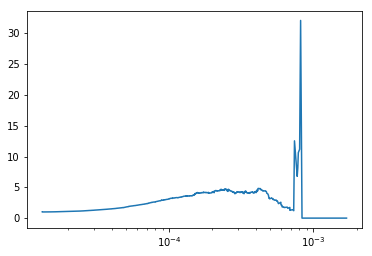

In [128]:
plt.xscale('log')
plt.plot(fin_pgr,features)
plt.show()

In [138]:
sorted_pgr = sorted(pagerank.items(), key=operator.itemgetter(1), reverse = True)
sp_keys = [float(b) for (a,b) in sorted_pgr]
print(len(sp_keys) != len(set(sp_keys)))

True


In [139]:
print(sp_keys)

[0.00170318373688099, 0.0009298355926681889, 0.0009005276311660342, 0.0008387034133328405, 0.0008361877809952189, 0.0008177063455503618, 0.0008050376334219899, 0.000788382583099261, 0.0007816514287760656, 0.0007743556217864901, 0.000741361038858943, 0.0007322468022830154, 0.0007237932924229044, 0.0007065588590957429, 0.0006901538325716295, 0.0006889834527718087, 0.0006883762470008862, 0.0006749997141879593, 0.0006654647055925303, 0.0006601841682386726, 0.0006470134393397561, 0.0006458085188586262, 0.0006394617423679684, 0.0006372379828555201, 0.0006274635604131289, 0.0006224108423009532, 0.0006098330474289262, 0.0006079070781568649, 0.0006073455483150611, 0.0006031915464318257, 0.0005990387078954609, 0.0005967193607083608, 0.0005967096062280244, 0.0005964674576021343, 0.0005960748071113137, 0.0005898081882260201, 0.0005739681284665157, 0.0005724132005659443, 0.0005648353639742826, 0.0005594226464594777, 0.0005575843566696391, 0.0005558485226841963, 0.0005516236390795198, 0.000542244401

##### beware, they are quite long to compute each

In [3]:
def compute_page_rank_feature_for_authors(citation_set, node_info, G=None):
    if G != G:
        G = graph_authors(citation_set, node_info)
        bool = True
    else:
        bool = False
    
    pg_rk = nx.pagerank(G)
    pg_rk_features = []
    for citation in citation_set:
        source = citation[0]
        target = citation[1]
        
        index_source = IDs.index(source)
        index_target = IDs.index(target)
        
        source_authors = [element[3].split(",") for element in node_info if element[0]==source][0]
        target_authors = [element[3].split(",") for element in node_info if element[0]==target][0]
        
        feature = 0
        for auth in source_authors + target_authors:
            feature += pg_rk[auth]
        
        pg_rk_features.append(feature)
    
    if bool:
        return np.array(pg_rk_features), G
    else:
        return np.array(pg_rk_features)

In [26]:
def compute_rich_club_feature_for_articles(citation_set, G=None):
    if G != G:
        G = graph_articles(citation_set)
        bool = True
    else:
        bool = False
    
    rc_cl = nx.richclub.rich_club_coefficient(G)
    
    rc_cl_features = []
    for citation in citation_set:
        rc_cl_features.append(rc_cl[citation[0]] + rc_cl[citation[1]])
    
    if bool:
        return np.array(rc_cl_features), G
    else:
        return np.array(rc_cl_features)

In [25]:
def compute_rich_club_feature_for_authors(citation_set, node_info, G=None):
    if G != G:
        G = graph_authors(citation_set, node_info)
        bool = True
    else:
        bool = False
    
    rc_cl = nx.richclub.rich_club_coefficient(G)
    rc_cl_features = []
    for citation in citation_set:
        source = citation[0]
        target = citation[1]
        
        index_source = IDs.index(source)
        index_target = IDs.index(target)
        
        source_authors = [element[3].split(",") for element in node_info if element[0]==source][0]
        target_authors = [element[3].split(",") for element in node_info if element[0]==target][0]
        
        feature = 0
        for auth in source_authors + target_authors:
            feature += rc_cl[auth]
        
        rc_cl_features.append(feature)
    
    if bool:
        return np.array(rc_cl_features), G
    else:
        return np.array(rc_cl_features)

In [16]:
def compute_shorthest_path_feature_for_articles(citation_set,G=None):
    if G != G:
        G = graph_articles(citation_set)
        bool = True
    else:
        bool = False
    
    sht_pth_features = []
    for citation in citation_set:
        if citation[2] == '1':
            G.remove_edge(citation[0], citation[1])
        sht_pth_features.append(
                nx.shortest_path_length(G,citation[0], citation[1]) if nx.has_path(G, citation[0], citation[1]) else 30)
        if citation[2] == '1':
            G.add_edge(citation[0], citation[1])
    
    if bool:
        return np.array(sht_pth_features), G
    else:
        return np.array(sht_pth_features)